# Train Interspeech

## Data

In [10]:
balanced = False

In [11]:
preprocessed = False

In [12]:
import pandas as pd

# Cargar el CSV para male
# data = pd.read_csv('data/data_male.csv')
data = pd.read_csv('data/balanced_pseudo_male.csv')

print(len(data))
# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
#data.to_csv('data/data_male.csv', index=False)
print(len(data))
data.head()

6384
6384


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set,PodcastID,StratifyCol,NewPartition,PseudoEmo,InvEntropyNorm,PseudoEmoNum
0,MSP-PODCAST_4583_0017_0001,"from what it looks like, heidi was okay with j...",A,4.8,2.8,5.2,2357,Male,Train,4583,4583_2357_A,Train,A,1.0,2
1,MSP-PODCAST_3162_0475,gave them extra money and then they decided th...,A,6.2,2.6,6.2,2124,Male,Development,3162,3162_2124_A,Train,A,1.0,2
2,MSP-PODCAST_2355_0349,"yes, you're going to fucking die.",A,4.2,2.6,4.8,1601,Male,Train,2355,2355_1601_A,Test,A,1.0,2
3,MSP-PODCAST_5201_1197,and i already kind of had it in my mind,A,5.2,3.6,5.4,2789,Male,Development,5201,5201_2789_A,Train,A,1.0,2
4,MSP-PODCAST_5583_1543,i'm talking about a lot of you guys got to sta...,A,4.8,3.4,4.8,2953,Male,Train,5583,5583_2953_A,Train,A,1.0,2


In [13]:
if balanced:
    # Paso 1: Determinar el tamaño mínimo entre las clases
    min_count = data['PseudoEmo'].value_counts().min()

    # Paso 2: Submuestrear cada clase
    data = data.groupby('PseudoEmo').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    # Paso 3: Verificar el balance
    print(data['PseudoEmo'].value_counts())
    print(len(data))

    #data.to_csv('data/balanced_pseudo_male.csv', index=False)


In [14]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                     FileName  \
0  MSP-PODCAST_4583_0017_0001   
1       MSP-PODCAST_3162_0475   
3       MSP-PODCAST_5201_1197   
4       MSP-PODCAST_5583_1543   
6       MSP-PODCAST_2736_0392   

                                                text EmoClass  EmoAct  EmoVal  \
0  from what it looks like, heidi was okay with j...        A     4.8     2.8   
1  gave them extra money and then they decided th...        A     6.2     2.6   
3            and i already kind of had it in my mind        A     5.2     3.6   
4  i'm talking about a lot of you guys got to sta...        A     4.8     3.4   
6  like you have an outside porch, like a screen ...        X     5.0     2.6   

   EmoDom  SpkrID Gender    Split_Set  PodcastID  StratifyCol NewPartition  \
0     5.2    2357   Male        Train       4583  4583_2357_A        Train   
1     6.2    2124   Male  Development       3162  3162_2124_A        Train   
3     5.4    2789   Male  Development       5201  5201_2789_A   

In [15]:
# # Establecer la semilla para garantizar reproducibilidad
# seed = 42

# # Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
# train_df = train_df.sample(n=1000, random_state=seed)

# # Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
# dev_df = dev_df.sample(n=250, random_state=seed)

In [16]:
num_labels = 8
id2label = dict(zip(train_df["PseudoEmoNum"], train_df["PseudoEmo"]))
label2id = dict(zip(train_df["PseudoEmo"], train_df["PseudoEmoNum"]))
print(f"{id2label=}")
print(f"{label2id=}")

id2label={2: 'A', 4: 'C', 6: 'D', 7: 'F', 1: 'H', 0: 'N', 3: 'S', 5: 'U'}
label2id={'A': 2, 'C': 4, 'D': 6, 'F': 7, 'H': 1, 'N': 0, 'S': 3, 'U': 5}


In [17]:
# Convertir EmoClass a valores numéricos si es necesario
train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
test_df['PseudoEmoNum'] = test_df['PseudoEmoNum'].astype(int)

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_37904/2335822977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_37904/2335822977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_37904/2335822977.py:4: SettingWithCopyWarning: 
A value is trying to be s

In [18]:
from datasets import Dataset
from transformers import AutoTokenizer


if preprocessed == False:
    # Modelo
    # model_ckpt = "distilbert-base-uncased"
    model_ckpt = "distilroberta-base"

    # Cargar el tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Función para tokenizar los datos
    def tokenize_function(examples):
        # Verificar que estamos pasando una lista de textos
        texts = examples['text']
        return tokenizer(texts, padding="max_length", truncation=True)

    # Asegurarse de que 'train_df' y 'dev_df' son objetos Dataset de Hugging Face
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)


    # Tokenizamos ambos conjuntos de datos
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    dev_dataset = dev_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)


    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
    dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
    test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")


In [19]:
import re
from datasets import Dataset
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

if preprocessed:
    # Descargar recursos necesarios de NLTK
    nltk.download('stopwords')
    nltk.download('wordnet')

    # Modelo
    model_ckpt = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    # Stopwords en inglés (puedes cambiar el idioma si es necesario)
    stop_words = set(stopwords.words('english'))

    # Inicializar el lematizador
    lemmatizer = WordNetLemmatizer()

    # Función para limpiar y tokenizar
    def preprocess_and_tokenize(examples):
        processed_texts = []
        for text in examples['text']:
            # Convertir a minúsculas
            text = text.lower()
            # # Eliminar URLs
            # text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
            # # Eliminar menciones y hashtags
            # text = re.sub(r"@\w+|#\w+", "", text)
            # # Eliminar caracteres especiales y puntuación
            # text = re.sub(r"[^a-zA-Z\s]", "", text)
            # # Eliminar números
            # text = re.sub(r"\d+", "", text)
            # # Eliminar palabras de parada
            # words = text.split()
            # words = [word for word in words if word not in stop_words]
            # # Aplicar lematización
            # words = [lemmatizer.lemmatize(word) for word in words]
            # # Unir palabras limpias
            # text = " ".join(words)
            # Añadir texto procesado a la lista
            processed_texts.append(text)
        
        # Tokenizar el texto limpio
        return tokenizer(processed_texts, padding="max_length", truncation=True)

    # Verificar que no haya valores nulos
    train_df = train_df.dropna(subset=["text", "PseudoEmoNum"])
    dev_df = dev_df.dropna(subset=["text", "PseudoEmoNum"])
    test_df = test_df.dropna(subset=["text", "PseudoEmoNum"])

    # Convertir DataFrame a Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Tokenizar los conjuntos de datos
    train_dataset = train_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    dev_dataset = dev_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)
    test_dataset = test_dataset.map(preprocess_and_tokenize, batched=True, num_proc=4)

    # Renombrar columna de labels
    train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
    dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
    test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")

    # Inspeccionar un ejemplo procesado
    print(train_dataset[0])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgegarcelan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorgegarcelan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Map (num_proc=4): 100%|██████████| 2341/2341 [00:00<00:00, 8893.03 examples/s]

{'FileName': 'MSP-PODCAST_4583_0017_0001', 'text': "from what it looks like, heidi was okay with jared exploring his feelings with holly and that's when things got messy.", 'EmoClass': 'A', 'EmoAct': 4.8, 'EmoVal': 2.8, 'EmoDom': 5.2, 'SpkrID': 2357, 'Gender': 'Male', 'Split_Set': 'Train', 'PodcastID': 4583, 'StratifyCol': '4583_2357_A', 'NewPartition': 'Train', 'PseudoEmo': 'A', 'InvEntropyNorm': 1.0, 'labels': 2, '__index_level_0__': 0, 'input_ids': [101, 2013, 2054, 2009, 3504, 2066, 1010, 21372, 2001, 3100, 2007, 8334, 11131, 2010, 5346, 2007, 9079, 1998, 2008, 1005, 1055, 2043, 2477, 2288, 18307, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Code

In [20]:
from transformers import AutoTokenizer
import torch
print(torch.__version__)  # Esto debería mostrarte la versión de PyTorch instalada

2.5.1


In [21]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
print(model.num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Obtener reporte completo
    report = classification_report(labels, predictions, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [23]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-male"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    #push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_37904/672696009.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,2.046200,1.971582,0.280730,0.149043,0.193912,"[[111, 40, 71, 1, 0, 0, 0, 0], [72, 99, 44, 0, 0, 0, 0, 0], [34, 11, 140, 1, 0, 0, 0, 0], [68, 18, 57, 4, 0, 0, 0, 0], [27, 14, 72, 0, 0, 0, 0, 0], [53, 26, 48, 2, 0, 0, 0, 0], [31, 13, 68, 3, 0, 0, 0, 0], [62, 18, 51, 1, 0, 1, 0, 0]]"
2,1.907600,1.887296,0.306899,0.207738,0.249570,"[[145, 17, 30, 25, 4, 2, 0, 0], [93, 81, 23, 11, 3, 3, 0, 1], [40, 8, 113, 19, 2, 2, 2, 0], [74, 7, 27, 36, 0, 0, 1, 2], [42, 4, 39, 13, 4, 7, 2, 2], [66, 22, 23, 12, 3, 3, 0, 0], [42, 9, 38, 20, 1, 3, 2, 0], [71, 6, 31, 17, 2, 3, 0, 3]]"
3,1.751800,1.881566,0.314830,0.226253,0.265749,"[[87, 38, 22, 59, 4, 3, 8, 2], [48, 110, 23, 25, 4, 0, 3, 2], [15, 13, 106, 35, 2, 1, 11, 3], [35, 12, 18, 76, 0, 0, 4, 2], [18, 15, 38, 25, 3, 3, 6, 5], [29, 40, 19, 32, 1, 2, 5, 1], [18, 11, 39, 35, 1, 2, 7, 2], [35, 18, 29, 38, 4, 1, 2, 6]]"
4,1.592600,1.883587,0.294211,0.228545,0.265454,"[[99, 29, 26, 27, 25, 7, 4, 6], [65, 90, 21, 10, 13, 9, 1, 6], [20, 7, 109, 18, 18, 8, 5, 1], [49, 8, 24, 42, 7, 2, 9, 6], [25, 5, 38, 10, 15, 9, 5, 6], [37, 27, 19, 11, 18, 8, 4, 5], [16, 7, 38, 19, 15, 9, 4, 7], [48, 9, 28, 16, 16, 5, 7, 4]]"
5,1.430000,1.927891,0.291039,0.223783,0.261937,"[[98, 36, 22, 30, 14, 6, 6, 11], [57, 102, 13, 13, 12, 9, 2, 7], [21, 11, 95, 23, 16, 7, 10, 3], [46, 14, 18, 47, 7, 1, 10, 4], [25, 9, 28, 14, 8, 12, 5, 12], [38, 35, 15, 12, 14, 5, 5, 5], [18, 14, 34, 19, 12, 5, 5, 8], [48, 15, 24, 17, 12, 4, 6, 7]]"
6,1.278300,1.989727,0.291832,0.242944,0.275945,"[[90, 34, 18, 34, 15, 11, 11, 10], [51, 95, 14, 14, 15, 15, 3, 8], [16, 10, 81, 29, 12, 14, 21, 3], [43, 10, 11, 60, 7, 2, 9, 5], [17, 9, 23, 15, 11, 17, 10, 11], [30, 31, 15, 18, 11, 10, 9, 5], [13, 8, 24, 29, 7, 14, 13, 7], [39, 13, 15, 30, 12, 7, 9, 8]]"
7,1.156400,2.048149,0.283109,0.243874,0.275090,"[[86, 24, 20, 28, 21, 17, 12, 15], [59, 85, 15, 13, 15, 15, 4, 9], [17, 4, 88, 22, 14, 15, 22, 4], [38, 8, 18, 48, 8, 4, 11, 12], [16, 7, 23, 12, 16, 18, 10, 11], [32, 26, 15, 16, 16, 10, 6, 8], [13, 5, 27, 21, 11, 16, 13, 9], [37, 9, 20, 21, 17, 10, 8, 11]]"
8,1.040200,2.082558,0.279937,0.241579,0.272109,"[[91, 23, 19, 27, 19, 18, 13, 13], [61, 82, 14, 11, 13, 20, 4, 10], [19, 4, 84, 24, 13, 15, 20, 7], [43, 8, 15, 46, 6, 5, 10, 14], [19, 7, 23, 12, 15, 16, 8, 13], [33, 26, 15, 15, 15, 12, 4, 9], [16, 4, 26, 21, 7, 18, 13, 10], [43, 9, 18, 22, 11, 10, 10, 10]]"
9,0.974700,2.119732,0.272006,0.241684,0.270259,"[[83, 23, 19, 23, 19, 20, 13, 23], [57, 76, 14, 11, 15, 27, 4, 11], [15, 4, 82, 22, 15, 18, 21, 9], [41, 8, 17, 43, 7, 6, 10, 15], [15, 6, 24, 10, 14, 19, 9, 16], [27, 24, 15, 13, 16, 17, 4, 13], [12, 4, 25, 19, 10, 21, 13, 11], [33, 8, 18, 21, 16, 15, 7, 15]]"
10,0.906300,2.134712,0.272006,0.239571,0.269200,"[[79, 27, 19, 24, 20, 20, 13, 21], [53, 83, 15, 11, 16, 22, 4, 11], [15, 5, 82, 24, 12, 18, 24, 6], [36, 10, 18, 43, 8, 6, 10, 16], [13, 7, 23, 10, 14, 18, 11, 17], [25, 28, 14, 15, 16, 14, 5, 12], [10, 4, 26, 20, 10, 20, 13, 12], [29, 12, 17, 23, 15, 13, 9, 15]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=870, training_loss=1.4031805378267135, metrics={'train_runtime': 4917.8154, 'train_samples_per_second': 5.657, 'train_steps_per_second': 0.177, 'total_flos': 3685637357076480.0, 'train_loss': 1.4031805378267135, 'epoch': 10.0})

In [25]:
preds_output = trainer.predict(test_dataset)
preds_metrics = preds_output.metrics
preds_metrics

{'test_loss': 2.2716307640075684,
 'test_accuracy': 0.1952157197778727,
 'test_macro_f1': 0.19635097722920003,
 'test_weighted_f1': 0.191514446586325,
 'test_confusion_matrix': [[31, 24, 6, 18, 10, 12, 4, 16],
  [44, 81, 7, 13, 5, 19, 1, 13],
  [19, 11, 62, 24, 21, 13, 22, 17],
  [69, 30, 35, 90, 16, 17, 31, 34],
  [78, 34, 85, 47, 50, 47, 39, 29],
  [85, 85, 32, 35, 28, 37, 18, 23],
  [50, 16, 85, 60, 49, 53, 59, 40],
  [71, 32, 38, 81, 34, 31, 28, 47]],
 'test_runtime': 73.0062,
 'test_samples_per_second': 32.066,
 'test_steps_per_second': 1.014}

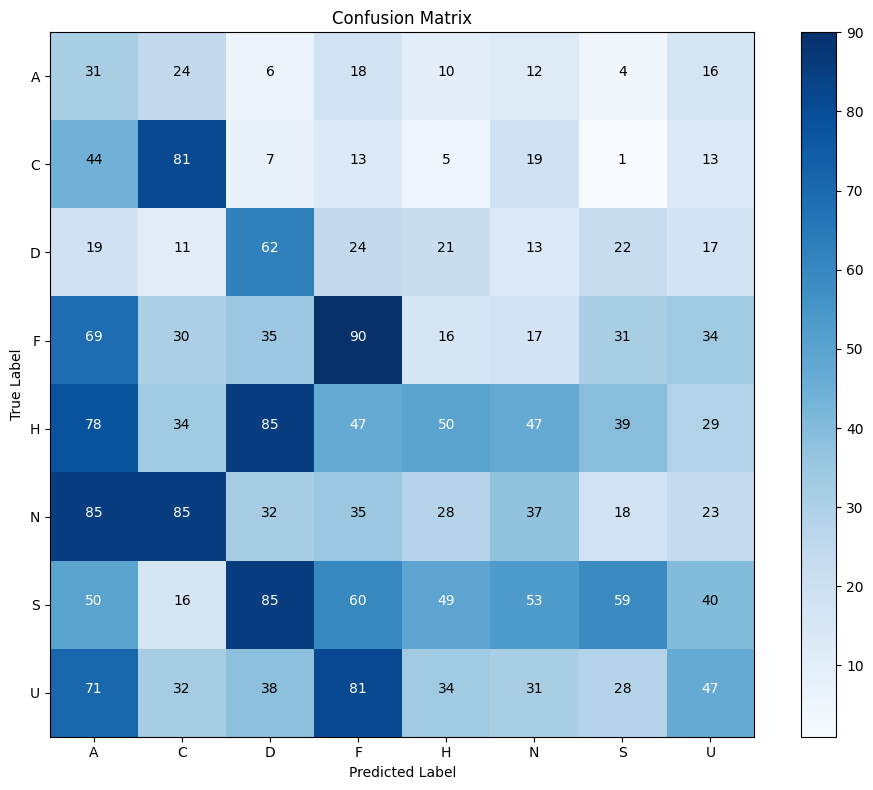

In [26]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = preds_metrics['test_confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()